In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame as df

import json
import corner

In [2]:
timing_data = json.load(open('timing_test_results.json', 'r'))

In [3]:
def cast_results_to_dataframe(input_data):
    output = []

    key_list = list(input_data[0]['parameters'].keys())
    key_list.append('duration')
    key_list.append('iterations')
    key_list.append('dt')
    key_list.append('eps')
    key_list.append('fd_timing')
    key_list.append('td_timing')

    for single in input_data:
        _output_list = list(single['parameters'].values())
        _output_list.append(single['duration'])
        _output_list.append(single['iterations'])
        for data in single['timing_results']:
            temp = _output_list.copy()
            temp.append(data['dt'])
            temp.append(data['eps'])
            temp.append(data['fd_timing'])
            temp.append(data['td_timing'])
            output.append(temp.copy())
        
    return df(output, columns=key_list), key_list

In [24]:
def corner_plot(dataframe, params, minmax=None, use_td=True, plot_ratio=False, eps_value=1e-2, dt_value=10.0):
    eps_range = np.unique(dataframe['eps'])
    dt_range = np.unique(dataframe['dt'])
    assert eps_value in eps_range
    assert dt_value in dt_range

    data_given_eps = dataframe[(dataframe['eps'] == eps_value)&(dataframe['dt'] == dt_value)]
    
    num_params = len(params)
    if not plot_ratio:
        timing_values = np.log10(data_given_eps['td_timing' if use_td else 'fd_timing'])
    else:
        timing_values = np.log10(data_given_eps['fd_timing']) - np.log10(data_given_eps['td_timing'])
    if not minmax:
        vmin = min(timing_values)
        vmax = max(timing_values)
    else:
        vmin, vmax = minmax
    
    fig, axes = plt.subplots(num_params, num_params, figsize=(15, 15))
    
    for i in range(num_params):
        for j in range(num_params):
            if i > j:
                im = axes[i, j].scatter(data_given_eps[params[j]], data_given_eps[params[i]], alpha=1, s=10, c=timing_values, vmax=vmax, vmin=vmin)
                if j == 0:
                    axes[i, j].set_ylabel(params[i])
                if i == num_params - 1:
                    axes[i, j].set_xlabel(params[j])
            else:
                axes[i, j].remove()

    fig.subplots_adjust(right=0.8)
    cbar_axis = fig.add_axes([0.7, 0.1, 0.02, 0.65])
    fig.colorbar(im, cax=cbar_axis,label='log10 time')
    # plt.tight_layout()
    plt.show()

In [5]:
data_df, param_names = cast_results_to_dataframe(timing_data)

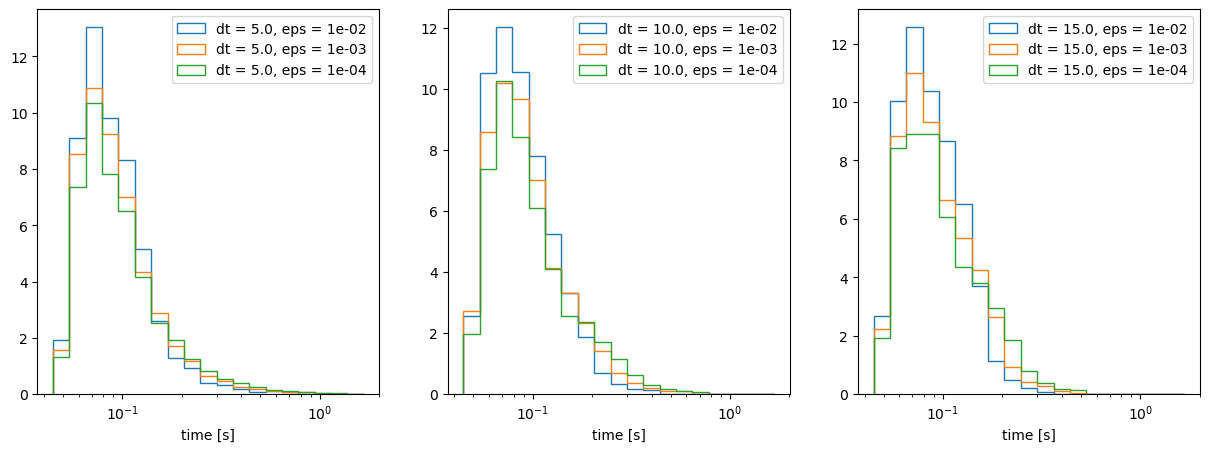

In [11]:
_min, _max = data_df['fd_timing'].min(), data_df['fd_timing'].max()
lb = np.logspace(np.log10(_min), np.log10(_max), 20)

fig, axs = plt.subplots(1,3,figsize=(15,5))
for ax, dt in zip(axs, [5.0, 10.0, 15.0]):
    for eps_val in [1e-2, 1e-3, 1e-4]:
        data = data_df[(data_df['eps'] == eps_val)&(data_df['dt'] == dt)]['fd_timing']
        ax.hist(data, density=True, bins=lb, histtype='step', label=f"dt = {dt}, eps = {eps_val:.0e}")
        ax.set_xscale('log')
        ax.set_xlabel('time [s]')
        ax.legend()

plt.show()

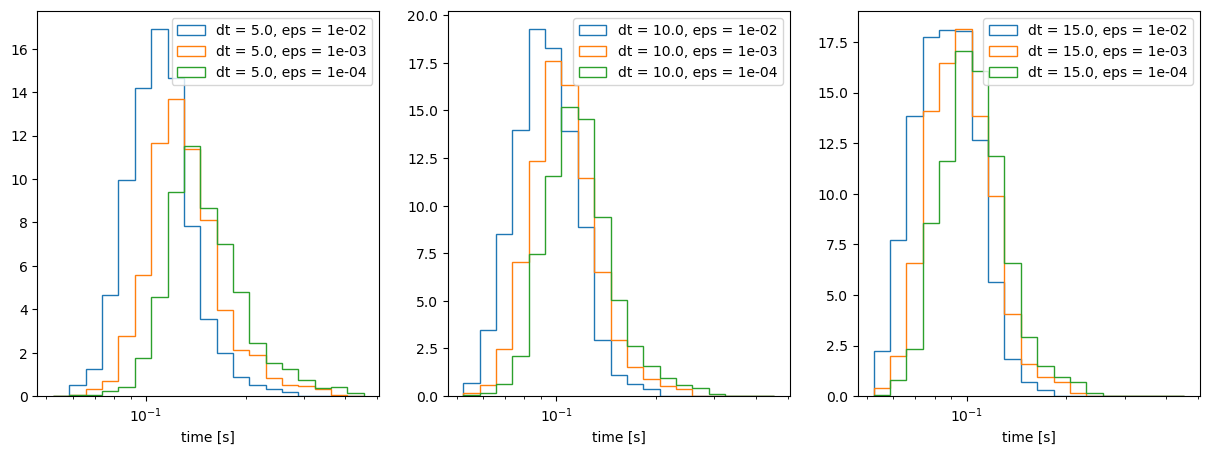

In [12]:
_min, _max = data_df['td_timing'].min(), data_df['td_timing'].max()
lb = np.logspace(np.log10(_min), np.log10(_max), 20)

fig, axs = plt.subplots(1,3,figsize=(15,5))
for ax, dt in zip(axs, [5.0, 10.0, 15.0]):
    for eps_val in [1e-2, 1e-3, 1e-4]:
        data = data_df[(data_df['eps'] == eps_val)&(data_df['dt'] == dt)]['td_timing']
        ax.hist(data, density=True, bins=lb, histtype='step', label=f"dt = {dt}, eps = {eps_val:.0e}")
        ax.set_xscale('log')
        ax.set_xlabel('time [s]')
        ax.legend()

plt.show()

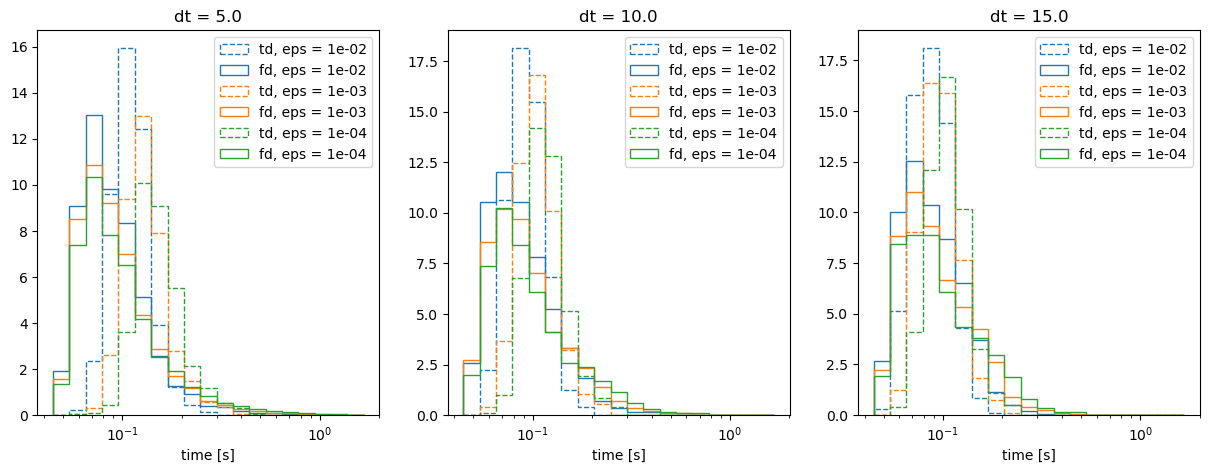

In [17]:
_min_fd, _max_fd = data_df['fd_timing'].min(), data_df['fd_timing'].max()
_min_td, _max_td = data_df['td_timing'].min(), data_df['td_timing'].max()
_min, _max = min([_min_fd, _min_td]), max([_max_fd, _max_td])
lb = np.logspace(np.log10(_min), np.log10(_max), 20)

fig, axs = plt.subplots(1,3,figsize=(15,5))
for ax, dt in zip(axs, [5.0, 10.0, 15.0]):
    for eps_val, pc in zip([1e-2, 1e-3, 1e-4], ['tab:blue', 'tab:orange', 'tab:green']):
        data_td = data_df[(data_df['eps'] == eps_val)&(data_df['dt'] == dt)]['td_timing']
        data_fd = data_df[(data_df['eps'] == eps_val)&(data_df['dt'] == dt)]['fd_timing']
        ax.hist(data_td, density=True, bins=lb, histtype='step', label=f"td, eps = {eps_val:.0e}", linestyle='--', color=pc)
        ax.hist(data_fd, density=True, bins=lb, histtype='step', label=f"fd, eps = {eps_val:.0e}", color=pc)
        ax.set_xscale('log')
        ax.set_xlabel('time [s]')
        ax.set_title(f"dt = {dt}")
        ax.legend()
        
plt.show()

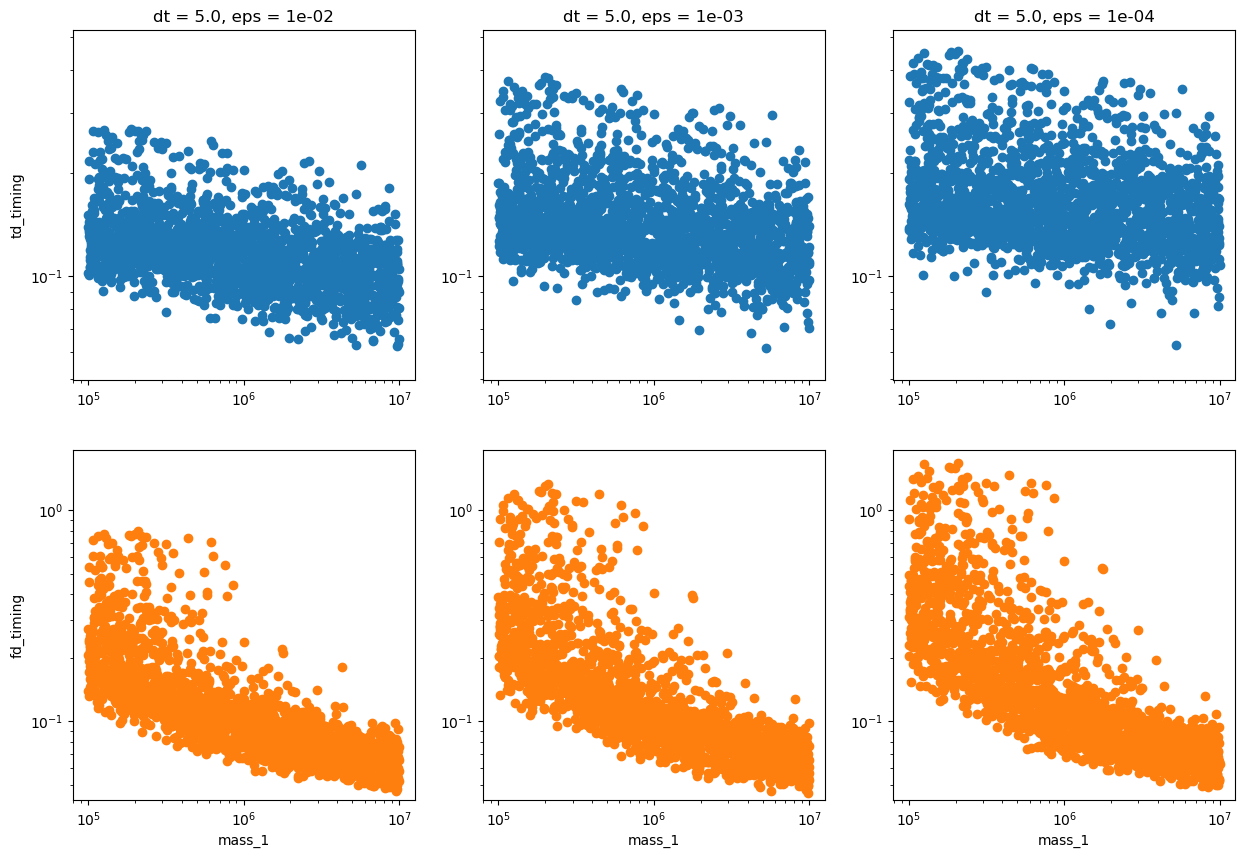

In [19]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

x_coord = 'mass_1'
dt = 5.0

for ax, timing, pc in zip(axs, ['td_timing', 'fd_timing'], ['tab:blue', 'tab:orange']):
    for eps_val, _a in zip([1e-2, 1e-3, 1e-4],ax):
        tmp_eps = data_df[[x_coord , timing, 'eps', 'dt']]
        _max, _min = data_df[timing].max(), data_df[timing].min()
        tmp = tmp_eps[(tmp_eps['eps'] == eps_val)&(tmp_eps['dt'] == dt)].to_numpy()
        _a.scatter(tmp.T[0], tmp.T[1], c=pc)
        _a.set_ylim(_min*0.95, _max*1.15)
        _a.set_xscale('log')
        _a.set_yscale('log')
        if eps_val == 1e-2:
            _a.set_ylabel(timing)

        if timing == 'td_timing':
            _a.set_title(f'dt = {dt}, eps = {eps_val:.0e}')

for ax in axs[-1]:
    ax.set_xlabel(x_coord)

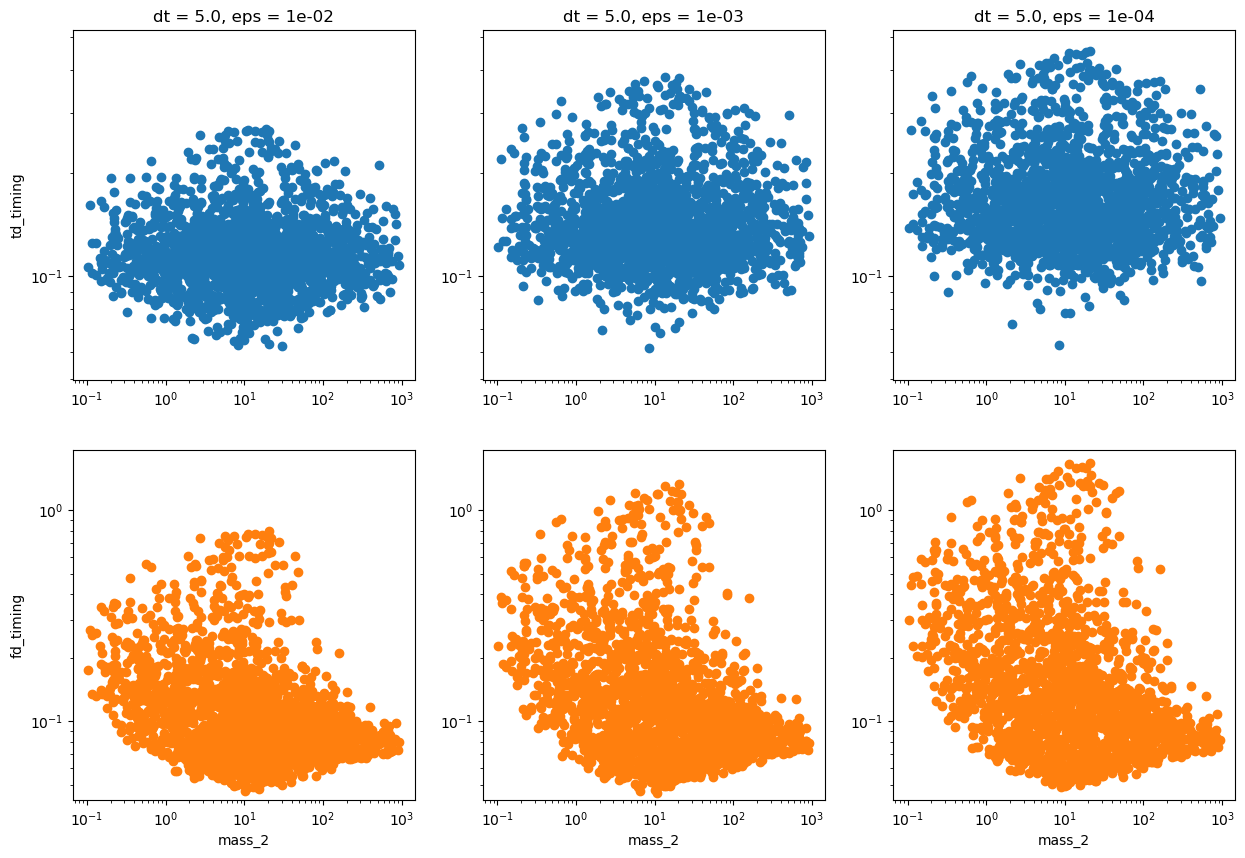

In [20]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

x_coord = 'mass_2'
dt = 5.0

for ax, timing, pc in zip(axs, ['td_timing', 'fd_timing'], ['tab:blue', 'tab:orange']):
    for eps_val, _a in zip([1e-2, 1e-3, 1e-4],ax):
        tmp_eps = data_df[[x_coord , timing, 'eps', 'dt']]
        _max, _min = data_df[timing].max(), data_df[timing].min()
        tmp = tmp_eps[(tmp_eps['eps'] == eps_val)&(tmp_eps['dt'] == dt)].to_numpy()
        _a.scatter(tmp.T[0], tmp.T[1], c=pc)
        _a.set_ylim(_min*0.95, _max*1.15)
        _a.set_xscale('log')
        _a.set_yscale('log')
        if eps_val == 1e-2:
            _a.set_ylabel(timing)

        if timing == 'td_timing':
            _a.set_title(f'dt = {dt}, eps = {eps_val:.0e}')

for ax in axs[-1]:
    ax.set_xlabel(x_coord)

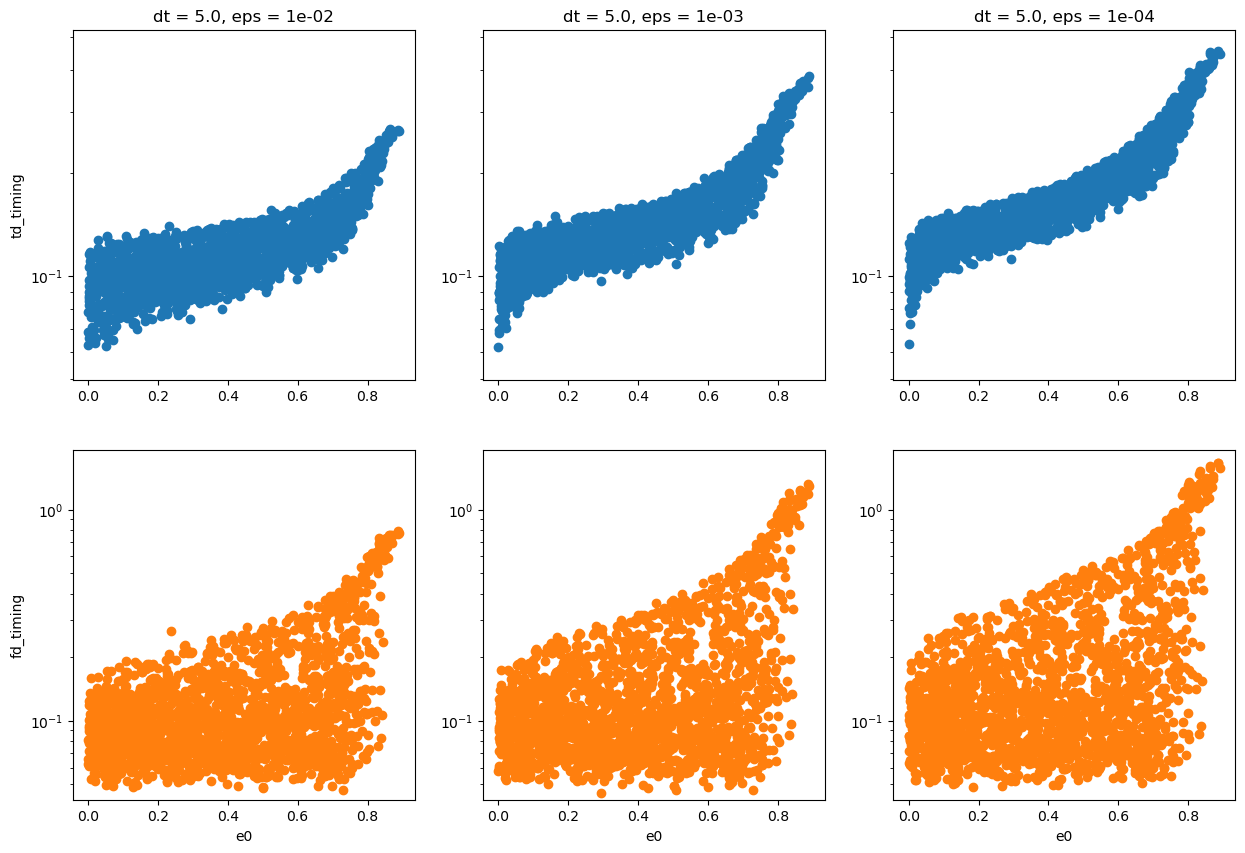

In [21]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

x_coord = 'e0'
dt = 5.0

for ax, timing, pc in zip(axs, ['td_timing', 'fd_timing'], ['tab:blue', 'tab:orange']):
    for eps_val, _a in zip([1e-2, 1e-3, 1e-4],ax):
        tmp_eps = data_df[[x_coord , timing, 'eps', 'dt']]
        _max, _min = data_df[timing].max(), data_df[timing].min()
        tmp = tmp_eps[(tmp_eps['eps'] == eps_val)&(tmp_eps['dt'] == dt)].to_numpy()
        _a.scatter(tmp.T[0], tmp.T[1], c=pc)
        _a.set_ylim(_min*0.95, _max*1.15)
        # _a.set_xscale('log')
        _a.set_yscale('log')
        if eps_val == 1e-2:
            _a.set_ylabel(timing)

        if timing == 'td_timing':
            _a.set_title(f'dt = {dt}, eps = {eps_val:.0e}')

for ax in axs[-1]:
    ax.set_xlabel(x_coord)

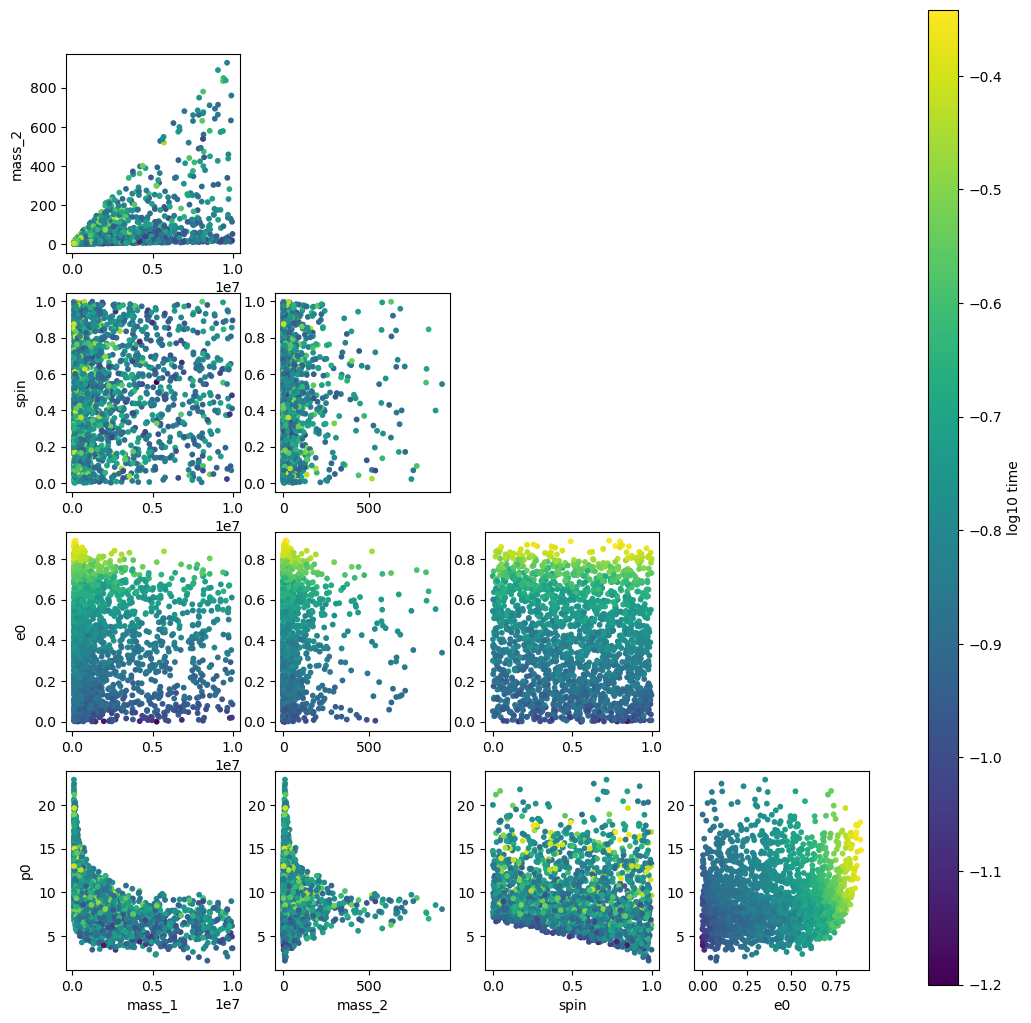

In [25]:
corner_plot(data_df, ['mass_1', 'mass_2', 'spin', 'e0', 'p0'], eps_value=1e-4, dt_value=5.0)
plt.show()

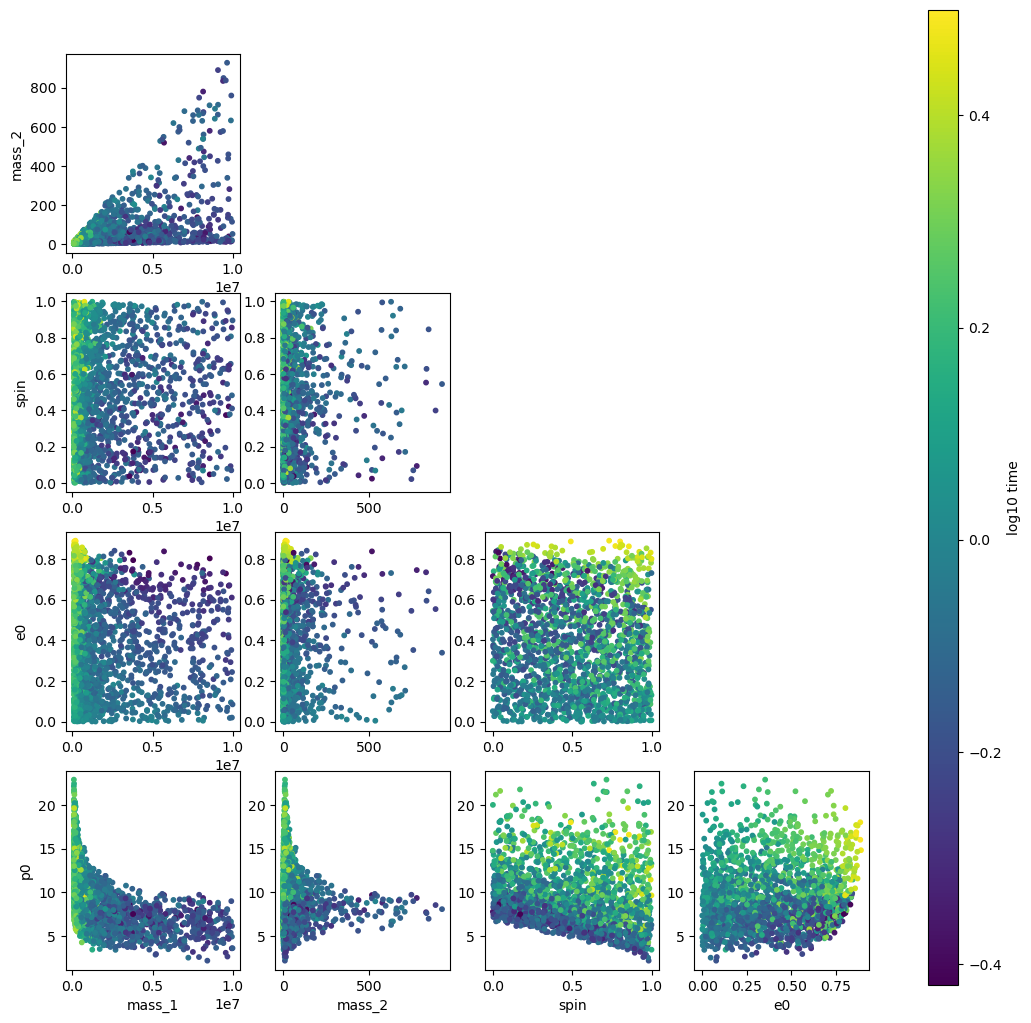

In [26]:
corner_plot(data_df, ['mass_1', 'mass_2', 'spin', 'e0', 'p0'], plot_ratio=True, eps_value=1e-4)